tensor([ 8.1949e-02,  1.2801e-01,  1.1496e-01,  3.2891e-01,  2.4752e-01,
         1.4400e-02,  1.5466e-01,  2.3361e-01,  9.2468e-02,  3.3184e-01,
         3.2749e-01, -1.5706e-01, -1.0523e-02,  2.0723e-01,  6.3087e-02,
         2.2591e-01,  1.4568e-01,  3.4784e-01,  4.6360e-01,  1.2274e-01,
         2.2077e-01,  1.4423e-01,  3.0287e-01,  2.6271e-01,  2.0824e-01,
         4.0749e-01,  5.6981e-01,  2.5716e-01,  2.4733e-01,  2.2927e-01,
        -1.3682e-01,  3.0434e-01,  1.2768e-01,  4.5912e-01,  3.6920e-01,
         5.1294e-01,  5.1221e-02,  1.9277e-01,  6.1426e-01,  6.8828e-01,
         2.3801e-01,  4.2056e-01,  3.3986e-01,  2.9081e-01,  2.8615e-01,
         5.9018e-01,  4.6158e-01,  6.0127e-01,  6.6497e-01,  4.9873e-01,
         4.9630e-01,  6.6390e-01,  5.9227e-01,  6.8576e-01,  2.6783e-01,
        -5.8365e-03,  6.0045e-01,  5.3937e-01,  6.2800e-01,  8.3195e-01,
         6.6457e-01,  7.3774e-01,  9.4222e-01,  5.2475e-01,  4.9992e-01,
         7.9388e-01,  1.1235e+00,  7.2477e-01,  8.6

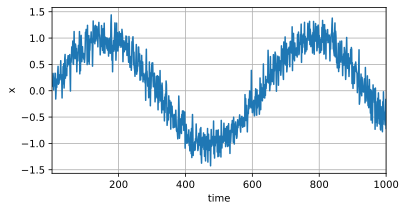

In [14]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,)) # 使用正弦函数和一些可加性噪声来生成序列数据
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))
print(x)

In [15]:
# 使用马尔科夫假设
tau = 4
features = torch.zeros((T - tau, tau)) # (样本, 特征)
print(features.shape) # (996, 4)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
print(features)
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

torch.Size([996, 4])
tensor([[ 0.0819,  0.1280,  0.1150,  0.3289],
        [ 0.1280,  0.1150,  0.3289,  0.2475],
        [ 0.1150,  0.3289,  0.2475,  0.0144],
        ...,
        [-0.4200, -0.5443, -0.5553, -0.6476],
        [-0.5443, -0.5553, -0.6476, -0.5207],
        [-0.5553, -0.6476, -0.5207, -0.1645]])


In [3]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.077815
epoch 2, loss: 0.060336
epoch 3, loss: 0.059550
epoch 4, loss: 0.054301
epoch 5, loss: 0.052725


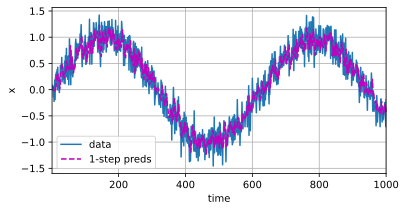

In [5]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

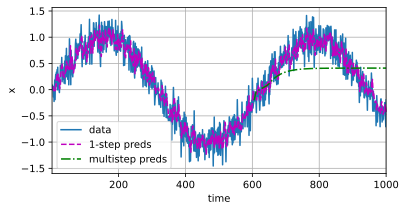

In [6]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

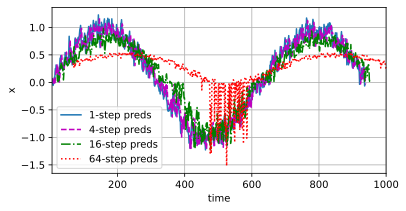

In [7]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

In [ ]:
# 逆天，64这个预测属实难绷，错的离谱